In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [71]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,168 kB]
Hit:14 http://ppa.launchpad.net/

In [72]:
import pandas as pd
import matplotlib
import os
import sys
import urllib.request
import datetime
import time
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

from collections import Counter
from konlpy.tag import Mecab
from google.colab import drive


drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [73]:
workspace_path = '/gdrive/My Drive/주가분석'
KOSPI_data_dir = os.path.join(workspace_path, 'KOSPI_data')
com_data_dir = os.path.join(workspace_path, 'com_data')
news_link_dir = os.path.join(workspace_path, 'news_link')
today_news_dir = os.path.join(workspace_path, 'today_news_link')
KOSPI_append_dir = os.path.join(workspace_path, 'KOSPI_data_append')
regression_data_dir = os.path.join(workspace_path, 'regression_data')
dir_list = sorted(os.listdir(KOSPI_data_dir))

## KOSPI 1월 ~ 3월 일별 데이터(시가총액 내림차순 정렬)

In [ ]:
data_frame_year = [] # data_frame_year[월][일]
names = []
for cur_dir in dir_list:
  data_frame_month = []
  name = []
  cur_dir = os.path.join(KOSPI_data_dir, cur_dir)
  file_list = os.listdir(cur_dir)
  for cur_file in file_list:
    name.append(cur_file.split('_')[1].split('.')[0])
    cur_file = os.path.join(cur_dir, cur_file)
    data_frame_day = pd.read_csv(cur_file, encoding = 'cp949').sort_values(by=['시가총액'], ascending = False)
    data_frame_month.append(data_frame_day)
  data_frame_year.append(data_frame_month)
  names.append(name)

In [ ]:
# top 100 기업 추출
top100 = data_frame_year[0][0][:100]['종목명']
com_list = data_frame_year[0][0][:]['종목명']

In [ ]:
top100

426        삼성전자
147      SK하이닉스
100       NAVER
420    삼성바이오로직스
427       삼성전자우
         ...   
38         GS건설
20        DB하이텍
838       한솔케미칼
854        한전기술
818      한국항공우주
Name: 종목명, Length: 100, dtype: object

## 기업별 데이터 생성

In [ ]:
sample = pd.read_csv('/gdrive/My Drive/주가분석/KOSPI_data/1월/data_20220103.csv', encoding = 'cp949')
com_dict = dict(zip(sample['종목명'], [[] for _ in range(len(sample))]))

for cur_dir in dir_list:
  cur_dir = os.path.join(KOSPI_data_dir, cur_dir)
  file_list = os.listdir(cur_dir)
  for cur_file in file_list:
    day = cur_file.split('_')[1].split('.')[0]
    cur_file = os.path.join(cur_dir, cur_file)
    data_frame_day = pd.read_csv(cur_file, encoding = 'cp949')
    data_frame_day['날짜'] = day
    
    for i in range(0, len(data_frame_day)):
      name = data_frame_day.loc[i]['종목명']
      try:
        com_dict[name].append(data_frame_day.loc[i])
      except KeyError:
        com_dict[name] = []

In [ ]:
#pd.DataFrame(com_dict['삼성전자']).tail()
com_dict['삼성전자'][0]

종목코드              005930
종목명                 삼성전자
종가                 78600
대비                   300
등락률                 0.38
시가                 79400
고가                 79800
저가                 78200
거래량             13502112
거래대금       1066006837750
시가총액     469224908430000
상장주식수         5969782550
날짜              20220103
Name: 426, dtype: object

In [ ]:
#com_data_dir에 기업별 데이터 저장
if not os.path.exists(com_data_dir):
  os.makedirs(com_data_dir)

for name in com_dict.keys():
  com_data_frame = pd.DataFrame(com_dict[name])
  com_data_frame.to_csv(os.path.join(com_data_dir, name) + '.csv')


##주가 데이터 추가

In [ ]:
append_list = os.listdir(KOSPI_append_dir)
append_list

['data_20220509.csv']

In [ ]:
append_list = os.listdir(KOSPI_append_dir)
append_list.sort()

sample = pd.read_csv(os.path.join(KOSPI_append_dir, append_list[0]), encoding = 'cp949')
com_dict = dict(zip(sample['종목명'], [[] for _ in range(len(sample))]))

for file in append_list:
  file_path = os.path.join(KOSPI_append_dir, file)
  data_frame_append = pd.read_csv(file_path, encoding = 'cp949')
  day = file.split('_')[1].split('.')[0]
  data_frame_append['날짜'] = day
  
  for com in data_frame_append['종목명']:
    if com_dict.get(com) is None:
      com_dict[com] = []
    [com_dict[com].append(line) for line in [data_frame_append[data_frame_append['종목명'] == com]]]
    


In [ ]:
pd.DataFrame(com_dict['삼성전자'][0])

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜
428,005930,삼성전자,66500,0,0.0,66300,66900,66100,5241105,348846284300,396990539575000,5969782550,20220509


In [ ]:
for com in com_dict.keys():
  com_file_path = os.path.join(com_data_dir, com + '.csv')
  
  if os.path.isfile(com_file_path):
    data_frame_com = pd.read_csv(com_file_path, encoding = 'UTF-8')
    for line in com_dict[com]:
      line = pd.DataFrame(line)
      if not data_frame_com.iloc[len(data_frame_com) - 1]['날짜'] >= int(line['날짜']):
        data_frame_com = data_frame_com.append(line)
    
  data_frame_com.drop(columns = ['Unnamed: 0'], inplace = True)
  data_frame_com.to_csv(os.path.join(com_data_dir, com + '.csv'))

In [ ]:
#특정 날짜만 업데이트(미완성)
for com in com_dict.keys():
  com_file_path = os.path.join(com_data_dir, com + '.csv')
  data_frame_com = pd.read_csv(com_file_path, encoding = 'UTF-8')
  for line in com_dict[com]:
    data_frame_com[data_frame_com['날짜'] == int(line['날짜'].values[0])].replace(line) 

  

In [ ]:
data_frame_com.tail(10)

,Unnamed: 0,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜
53,938.0,3280,흥아해운,2850,-35,-1.21,2885,2885,2800,550642,1565556400,685210962150,240424899,20220324
54,938.0,3280,흥아해운,2790,-60,-2.11,2850,2870,2780,623497,1755543805,670785468210,240424899,20220325
55,939.0,3280,흥아해운,2770,-20,-0.72,2795,2815,2730,574122,1585996600,665976970230,240424899,20220328
56,939.0,3280,흥아해운,2745,-25,-0.90,2755,2825,2710,555086,1542167000,659966347755,240424899,20220329
57,939.0,3280,흥아해운,2890,145,5.28,2785,3205,2735,10896198,32961482930,694827958110,240424899,20220330
58,939.0,3280,흥아해운,2910,20,0.69,2860,2950,2810,1181048,3403526510,699636456090,240424899,20220331
939,NaN,003280,흥아해운,2850,-60,-2.06,2885,2890,2820,548577,1560746225,685210962150,240424899,20220401
939,NaN,003280,흥아해운,2855,5,0.18,2870,2875,2785,780112,2253214125,686413086645,240424899,20220404
939,NaN,003280,흥아해운,3180,325,11.38,2985,3280,2970,10505494,33003491805,764551178820,240424899,20220405
939,NaN,003280,흥아해운,3060,-120,-3.77,3205,3260,2990,2035871,6402411920,735700190940,240424899,20220406


##네이버 API를 활용한 각 기업 뉴스 링크 저장

In [74]:
client_id = 'CQwzCYyTxfeamaoxWr7s'
client_secret = 'jSDxy71Vsh'

#[CODE 1]
def getRequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_secret)
    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
    return None

#[CODE 2]
def getNaverSearch(node, srcText, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(srcText), start, display)
    url = base + node + parameters
    responseDecode = getRequestUrl(url) #[CODE 1]
    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)


def getPostData(post, jsonResult, cnt):
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']
    pDate = datetime.datetime.strptime(post['pubDate'], '%a, %d %b %Y %H:%M:%S +0900')
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')
    jsonResult.append({'cnt':cnt, 'title':title, 'description': description, 'org_link':org_link, 'link': org_link, 'pDate':pDate})
    return

def clean_html(x):
  #https://predictor-ver1.tistory.com/4
  x = re.sub("\&\w*\;","",x)
  x = re.sub("<.*?>","",x)
  return x
def getDayNews(date, top100, search_num, save = False, latest = False):
  if not os.path.exists(today_news_dir):
    os.makedirs(today_news_dir)
  node = 'news' #크롤링할 대상
  top100com_today_news = []
  for com in top100:  
    srcText = com
    com_dir = os.path.join(today_news_dir, com)
    if not os.path.exists(com_dir):
      os.makedirs(com_dir)

    cnt = 0
    com_today_news = []
    jsonResponse = getNaverSearch(node, srcText, 1, search_num) #[CODE 2]
    
    print('%s %s' % (date, srcText))
    for post in jsonResponse['items']:
      
      pDate = datetime.datetime.strptime(post['pubDate'], '%a, %d %b %Y %H:%M:%S +0900')
      news_date = pDate.strftime('%Y%m%d%H%M')
      if latest is True:
        if date == news_date:
          cnt += 1
          getPostData(post, com_today_news, cnt) #[CODE 3]
      else:
        if date < news_date:
          cnt += 1
          getPostData(post, com_today_news, cnt) #[CODE 3]
    print('%d 건' % cnt)
    top100com_today_news.append(com_today_news)
    #print('전체 검색 : %d 건' %total)
    if save is True:
      with open(com_dir + '/%s_%s.json' % (date, srcText), 'w', encoding='utf8') as outfile:
          jsonFile = json.dumps(com_today_news, indent = 4, sort_keys = True, ensure_ascii = False)
          outfile.write(jsonFile)
          print("가져온 데이터 : %d 건" %(cnt))
          print('%s_naver_%s.json SAVED' % (srcText, node))
  return top100com_today_news
def getTop100():
  data_frame_day = pd.read_csv(KOSPI_data_dir + '/3월/data_20220331.csv', encoding = 'cp949').sort_values(by=['시가총액'], ascending = False)
  top100 = data_frame_day[:100]['종목명']
  return top100

In [ ]:
'''
#코스닥 940 여개 기업 뉴스 검색
node = 'news' #크롤링할 대상
if not os.path.exists(news_link_dir):
  os.makedirs(news_link_dir)
#len(com_list) : 942 ; 검색 API 942 * 10회 호출
for com in com_list:  
  srcText = com
  cnt = 0
  jsonResult = []
  jsonResponse = getNaverSearch(node, srcText, 1, 100) #[CODE 2]
  for post in jsonResponse['items']:
    cnt += 1
    getPostData(post, jsonResult, cnt) #[CODE 3]
  #total = jsonResponse['total']
  while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
      for post in jsonResponse['items']:
          cnt += 1
          getPostData(post, jsonResult, cnt) #[CODE 3]
      start = jsonResponse['start'] + jsonResponse['display']
      jsonResponse = getNaverSearch(node, srcText, start, 100) #[CODE 2]
  #print('전체 검색 : %d 건' %total)
  with open(news_link_dir + '/%s_naver_%s.json' % (srcText, node), 'w', encoding='utf8') as outfile:
      jsonFile = json.dumps(jsonResult, indent = 4, sort_keys = True, ensure_ascii = False)
      outfile.write(jsonFile)
  print("가져온 데이터 : %d 건" %(cnt))
  print('%s_naver_%s.json SAVED' % (srcText, node))
'''

## 뉴스 본문 대략적인 추출

In [75]:
def get_naver_news(url):
  res = requests.get(url)
  if res.status_code == 200:
    html = res.text
    soup = BeautifulSoup(html, 'html.parser')
    body = soup.find('body')    
    return body

def koreanLen(text):
    hangul = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')  
    result = hangul.findall(text)
    return len(''.join(result))

def getKorean(text):
    hangul = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')  
    result = hangul.findall(text)
    return result

def getNewsBody(link):
  N = 30
  try:
    body = get_naver_news(link)
  except:
    return
  if body is None:
    return
  text = body.get_text()

  news_body_start = []
  text_split = text.split(' ')
  rm_set = {''}
  text_split = [k for k in text_split if k not in rm_set]

  for word_index in range(0, len(text_split) - N):
    word_len = 0
    korean_word_len = 0
    for j in range(0, N):
      korean_word_len += koreanLen(text_split[word_index + j])
      word_len += len(text_split[word_index + j])
    news_body_start.append(korean_word_len / word_len)

  avg = []
  avg_index = []
  y = 0
  while y < len(text_split) - N:
    avg.append(sum(news_body_start[y:y + N]) / N)
    avg_index.append(y)
    y += N
  if len(avg) == 0:
    return
  max_index = avg.index(max(avg))
  avg_avg = sum(avg) / len(avg)
  y = 0
  start = max_index
  end = max_index
  while max_index > y:
    if avg[max_index - y] > avg_avg:
      start = max_index - y
    else:
      break
    y += 1
  y = 0
  while (y + max_index) < len(avg):
    if avg[max_index + y] > avg_avg:
      end = max_index + y
    else:
      break
    y += 1
  return ' '.join(text_split[avg_index[start] - N : avg_index[end] + N])

def morpheme_separation(sentence):
    mecab = Mecab()
    split_sentence=[]
    temp_X = mecab.pos(sentence)
    # http://openuiz.blogspot.com/2016/07/mecab-ko-dic.html
    for i in temp_X:
        if i[1]=='NNG' or i[1]=='NNP' or i[1]=='VV' or i[1]=='VX' or i[1]=='VA':
                if i[1]=='VA':#형용사 일때 '다'를 붙여줌 ex) 넓 + 다
                    split_sentence.append(i[0]+'다')
                else:
                    split_sentence.append(i[0])
    return split_sentence

In [ ]:
news_keywords = [ '출시',  '선보일', '상승한', '상승했다'  '신모델을' , '기술이다', '신제품에서는' , '제공하는' , '탑재하고' , '탑재했다' , '늘어나고' , '출시한' , '출시했다' , '강력한' , '출시된다' , '혁신을' , '제공하며' , '완성할' , '풍부해진' , '순매수했다' , '최적화된' , '고급스러운' , '출고가는' , '기록했다' , '돋보이는' , '늘었다' , '확대' , '압도적인' , '성능에' , '증가했다' , '마감했다' , '최고의' , '결과물이다' , '달성했다' , '올랐다' , '특징이다' , '팔아치웠다' , '예상된다' , '신제품들을' , '강세' , '이뤘다' , '실적이' , '분석했다' , '집계됐다' , '수준이다' , '완벽한' , '수요가' , '상승에' , '높이는' , '성장을' , '전망이다' , '밝혔습니다' , '차지했다' , '설명이다' , '계약을' , '대표적인' , '꼽힌다' , '기반으로' , '완화' , '출시했다고' , '가능성' , '제공한다' , '지속적으로' , '두드러졌다' , '가능하다' , '콘텐츠를' , '활용한' ,'높다', '줄었다' , '전략' , '영향으로' , '기록하며' ]

## 긍정, 부정 키워드 선형회귀 데이터 구축

In [76]:
positive_keyword = ['개선', '증가', '확대', '흑자', '호재']
negative_keyword = ['인플레이션', '스테그플레이션','역성장', '축소', '악재', '하락']

In [77]:
#top100 = ['제주항공','아시아나항공', '대한항공', '진에어']
top100 = getTop100()
news = getDayNews('202203091030', top100, 40, False, False) #(날짜, 검색 기업 리스트, 기업 당 검색 건수, 저장여부, 지정날짜의 기사만 검색할 지)

[2022-05-09 09:48:53.422721] Url Request Success
202203091030 삼성전자
40 건
[2022-05-09 09:48:54.171695] Url Request Success
202203091030 LG에너지솔루션
40 건
[2022-05-09 09:48:54.933762] Url Request Success
202203091030 SK하이닉스
40 건
[2022-05-09 09:48:55.650489] Url Request Success
202203091030 NAVER
40 건
[2022-05-09 09:48:56.339501] Url Request Success
202203091030 삼성바이오로직스
40 건
[2022-05-09 09:48:57.374062] Url Request Success
202203091030 삼성전자우
40 건
[2022-05-09 09:48:58.148685] Url Request Success
202203091030 카카오
40 건
[2022-05-09 09:48:59.139302] Url Request Success
202203091030 삼성SDI
40 건
[2022-05-09 09:48:59.843038] Url Request Success
202203091030 현대차
40 건
[2022-05-09 09:49:00.574166] Url Request Success
202203091030 LG화학
40 건
[2022-05-09 09:49:01.343980] Url Request Success
202203091030 기아
40 건
[2022-05-09 09:49:02.086619] Url Request Success
202203091030 POSCO홀딩스
40 건
[2022-05-09 09:49:02.820557] Url Request Success
202203091030 KB금융
40 건
[2022-05-09 09:49:03.542800] Url Request Success
20

In [78]:
def getKeywordCount(news_list, com_list, keyword_list):
  com_list = list(com_list)
  df_list = []
  columns = ['날짜'] + keyword_list
  for com_index, com_news in enumerate(news_list):
    
    count_df = pd.DataFrame(columns=columns)
    for one_news in com_news:
      news_body = getNewsBody(one_news['link'])
      if news_body is None:
        continue
      keyword_str = ' '.join(morpheme_separation(' '.join(getKorean(news_body))))
      
      keyword_cnt = []
      for keyword in keyword_list:
        cnt = keyword_str.count(keyword)
        keyword_cnt.append(cnt)
      day = ''.join(one_news['pDate'].split(' ')[0].split('-'))
      row = [int(day)] + keyword_cnt
      
      count_df = count_df.append(pd.Series(row, index = count_df.columns), ignore_index=True) 
    df_list.append(count_df.groupby('날짜').sum().rename_axis('날짜').reset_index())
  return df_list

In [79]:
keyword = positive_keyword + negative_keyword
count_df_list = getKeywordCount(news, top100, keyword)

In [80]:
def join(top100, count_df_list, save = False):
  data_frame_list = []
  for com_index, com in enumerate(top100):
    data_path = os.path.join(com_data_dir, com + '.csv')
    if os.path.isfile(data_path) is False:
      continue
    data_frame_com = pd.read_csv(data_path, encoding = 'UTF-8')
    data_frame = pd.merge(data_frame_com, count_df_list[com_index], how = 'left')
    data_frame_list.append(data_frame)
    if save is True:
      data_frame.to_csv(os.path.join(regression_data_dir, com) + '.csv')
  return data_frame_list
    

In [81]:
regression_df_list = join(top100, count_df_list, save = False)

In [82]:
regression_df = pd.DataFrame(columns = regression_df_list[0].columns)
for com_index, com_df in enumerate(regression_df_list):
  regression_df = regression_df.append(com_df.dropna())

In [83]:
if not os.path.exists(com_data_dir):
  os.makedirs(com_data_dir)
regression_df.drop(columns = ['Unnamed: 0'], inplace = True)
regression_df.to_csv(os.path.join(regression_data_dir, 'regression_data.csv'))

In [84]:
regression_df

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,...,증가,확대,흑자,호재,인플레이션,스테그플레이션,역성장,축소,악재,하락
84,5930,삼성전자,66500,0,0.00,66300,66900,66100,5241105,348846284300,...,18.0,30.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,25.0
65,373220,LG에너지솔루션,396000,-5500,-1.37,397000,400000,395500,72307,28742351500,...,5.0,10.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,37.0
84,660,SK하이닉스,108500,1000,0.93,107000,108500,106500,637886,68776512500,...,8.0,15.0,3.0,1.0,6.0,0.0,0.0,4.0,3.0,67.0
84,35420,NAVER,274500,2500,0.92,269500,276500,269000,211469,57801686620,...,4.0,19.0,0.0,0.0,10.0,0.0,0.0,0.0,3.0,83.0
84,207940,삼성바이오로직스,795000,1000,0.13,795000,800000,794000,7953,6334548000,...,6.0,24.0,0.0,0.0,17.0,0.0,0.0,0.0,4.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,990,DB하이텍,66200,-1700,-2.50,66700,67200,65700,646918,42851723700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
84,990,DB하이텍,64200,-2000,-3.02,65400,66300,64200,202924,13217078400,...,4.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
83,307950,현대오토에버,134500,-1000,-0.74,133000,136000,133000,35725,4812101500,...,21.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
84,307950,현대오토에버,127500,-7000,-5.20,134500,134500,127000,50725,6614318500,...,2.0,5.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0


##선형 회귀 모델 학습

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import torch

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [85]:
import torch

In [86]:
workspace_path = '/gdrive/My Drive/주가분석'
regression_data_dir = os.path.join(workspace_path, 'regression_data')

regression_data_path = os.path.join(regression_data_dir, 'regression_data.csv')

In [87]:
regression_data = pd.read_csv(regression_data_path, encoding = 'utf-8')

In [ ]:
regression_data.drop(columns = ['Unnamed: 0'], inplace = True)
#regression_data.drop(columns = ['Unnamed: 0.1'], inplace = True)

In [90]:
regression_data.head()

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,...,증가,확대,흑자,호재,인플레이션,스테그플레이션,역성장,축소,악재,하락
0,5930,삼성전자,66500,0,0.00,66300,66900,66100,5241105,348846284300,...,18.0,30.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,25.0
1,373220,LG에너지솔루션,396000,-5500,-1.37,397000,400000,395500,72307,28742351500,...,5.0,10.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,37.0
2,660,SK하이닉스,108500,1000,0.93,107000,108500,106500,637886,68776512500,...,8.0,15.0,3.0,1.0,6.0,0.0,0.0,4.0,3.0,67.0
3,35420,NAVER,274500,2500,0.92,269500,276500,269000,211469,57801686620,...,4.0,19.0,0.0,0.0,10.0,0.0,0.0,0.0,3.0,83.0
4,207940,삼성바이오로직스,795000,1000,0.13,795000,800000,794000,7953,6334548000,...,6.0,24.0,0.0,0.0,17.0,0.0,0.0,0.0,4.0,134.0


In [91]:
regression_data.drop(columns = ['종목코드', '종가', '대비', '시가', '고가', '거래량', '거래대금','시가총액', '상장주식수'], inplace = True)

In [92]:
regression_data.head()

,종목명,등락률,저가,날짜,개선,증가,확대,흑자,호재,인플레이션,스테그플레이션,역성장,축소,악재,하락
0,삼성전자,0.00,66100,20220509,7.0,18.0,30.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,25.0
1,LG에너지솔루션,-1.37,395500,20220509,0.0,5.0,10.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,37.0
2,SK하이닉스,0.93,106500,20220509,3.0,8.0,15.0,3.0,1.0,6.0,0.0,0.0,4.0,3.0,67.0
3,NAVER,0.92,269000,20220509,6.0,4.0,19.0,0.0,0.0,10.0,0.0,0.0,0.0,3.0,83.0
4,삼성바이오로직스,0.13,794000,20220509,2.0,6.0,24.0,0.0,0.0,17.0,0.0,0.0,0.0,4.0,134.0


In [93]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(regression_data[regression_data.columns[4:]].to_numpy(),regression_data['등락률'].to_numpy(), test_size=0.2)

In [94]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)
        #torch.nn.init.constant_(self.linear_classifier.weight.data, 0)

    def forward(self, x):
        print("inX:" ,x)
        print("inSquee",x.unsqueeze(0))
        x = self.linear_classifier(x.unsqueeze(0))
        print("outX:" ,x)
        return x


In [118]:
input_dim = len(regression_data.columns[4:])
output_dim = 1
learning_rate = 0.0001
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

In [96]:
def train(train_x, train_y, loss_function, optimizer, model):
  model.train()
  print(model.linear_classifier.weight)
  loss_list = []
  for idx in range(len(train_x)):
    
    optimizer.zero_grad()
    print(idx)
    print(train_x[idx])
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor.unsqueeze(0))
    print("the value of logit", logit)
    loss = loss_function(logit, train_y_tensor)
    loss_list.append(loss)
    print("the value of loss", loss)

    loss.backward()
    optimizer.step()

  return model, loss_list

In [119]:
best_model = None
best_model, loss_list = train(train_x, train_y, loss_function, optimizer, model)

Parameter containing:
tensor([[ 0.2041,  0.0323,  0.2644,  0.2384, -0.1108,  0.2519,  0.1100, -0.2405,
         -0.1781, -0.1088,  0.1721]], requires_grad=True)
0
[ 2.  5.  1.  2.  0.  0.  0.  0.  2.  0. 20.]
inX: tensor([[ 2.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0., 20.]])
inSquee tensor([[[ 2.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0., 20.]]])
outX: tensor([[[4.1315]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[4.1315]]], grad_fn=<AddBackward0>)
the value of loss tensor(17.0443, grad_fn=<MseLossBackward0>)
1
[ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0. 11.]
inX: tensor([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 11.]])
inSquee tensor([[[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 11.]]])
outX: tensor([[[2.3274]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[2.3274]]], grad_fn=<AddBackward0>)
the value of loss tensor(10.3518, grad_fn=<MseLossBackward0>)
2
[ 1.  0.  5.  0.  0.  0.  0.  0.  1.  0. 19.]
inX: tensor([[ 1.,  0.,  5.,  0.,  0.,  0.,  0.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[2.9381]]], grad_fn=<AddBackward0>)
the value of loss tensor(8.6327, grad_fn=<MseLossBackward0>)
24
[1. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0.]
inX: tensor([[1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.0491]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[-0.0491]]], grad_fn=<AddBackward0>)
the value of loss tensor(1.9297, grad_fn=<MseLossBackward0>)
25
[ 5.  7.  6.  0.  0.  1.  0.  0.  1.  1. 19.]
inX: tensor([[ 5.,  7.,  6.,  0.,  0.,  1.,  0.,  0.,  1.,  1., 19.]])
inSquee tensor([[[ 5.,  7.,  6.,  0.,  0.,  1.,  0.,  0.,  1.,  1., 19.]]])
outX: tensor([[[-1.2138]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[-1.2138]]], grad_fn=<AddBackward0>)
the value of loss tensor(0.3797, grad_fn=<MseLossBackward0>)
26
[ 2. 30.  7.  0.  2.  1.  0.  0.  1.  0. 18.]
inX: tensor([[ 2., 30.,  7.,  0.,  2.,  1.,  0.,  0.,  1.,  0., 18.]])
inSquee tensor([[[ 2., 30.,  7.,  0.,  2.,  1.,  0.,  0.,  

In [120]:
import matplotlib.pyplot as plt
loss = [loss_tensor.item() for loss_tensor in loss_list]

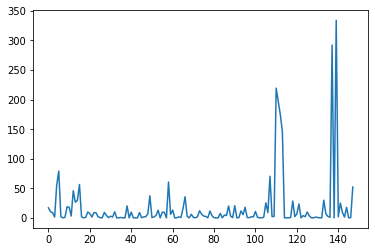

In [121]:
plt.plot(loss)

##선형 회귀 모델을 이용한 주가 예측

In [105]:
top100 = getTop100()
news = getDayNews('202205091030', top100, 1, False, False) #(날짜, 검색 기업 리스트, 기업 당 검색 건수, 저장여부, 지정날짜의 기사만 검색할 지)

[2022-05-09 11:24:27.224116] Url Request Success
202205091030 삼성전자
1 건
[2022-05-09 11:24:27.804251] Url Request Success
202205091030 LG에너지솔루션
1 건
[2022-05-09 11:24:28.552146] Url Request Success
202205091030 SK하이닉스
1 건
[2022-05-09 11:24:29.092170] Url Request Success
202205091030 NAVER
1 건
[2022-05-09 11:24:29.658267] Url Request Success
202205091030 삼성바이오로직스
1 건
[2022-05-09 11:24:30.458464] Url Request Success
202205091030 삼성전자우
1 건
[2022-05-09 11:24:31.037943] Url Request Success
202205091030 카카오
1 건
[2022-05-09 11:24:31.632519] Url Request Success
202205091030 삼성SDI
1 건
[2022-05-09 11:24:32.450257] Url Request Success
202205091030 현대차
1 건
[2022-05-09 11:24:33.175624] Url Request Success
202205091030 LG화학
1 건
[2022-05-09 11:24:33.979957] Url Request Success
202205091030 기아
1 건
[2022-05-09 11:24:34.538946] Url Request Success
202205091030 POSCO홀딩스
1 건
[2022-05-09 11:24:35.158121] Url Request Success
202205091030 KB금융
1 건
[2022-05-09 11:24:35.776721] Url Request Success
202205091030 카카

In [122]:
keyword = positive_keyword + negative_keyword
count_df_list = getKeywordCount(news, top100, keyword)

In [123]:
count_df_list[0][count_df_list[0].columns[1:]].to_numpy()

array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]])

In [124]:
best_model, loss_list = train(train_x, train_y, loss_function, optimizer, model)

Parameter containing:
tensor([[-0.0163,  0.0111,  0.1843,  0.1929, -0.1197,  0.2214,  0.1100, -0.2405,
         -0.2250, -0.1409,  0.0254]], requires_grad=True)
0
[ 2.  5.  1.  2.  0.  0.  0.  0.  2.  0. 20.]
inX: tensor([[ 2.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0., 20.]])
inSquee tensor([[[ 2.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0., 20.]]])
outX: tensor([[[0.3524]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[0.3524]]], grad_fn=<AddBackward0>)
the value of loss tensor(62.5299, grad_fn=<MseLossBackward0>)
1
[ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0. 11.]
inX: tensor([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 11.]])
inSquee tensor([[[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 11.]]])
outX: tensor([[[0.7372]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[0.7372]]], grad_fn=<AddBackward0>)
the value of loss tensor(2.6479, grad_fn=<MseLossBackward0>)
2
[ 1.  0.  5.  0.  0.  0.  0.  0.  1.  0. 19.]
inX: tensor([[ 1.,  0.,  5.,  0.,  0.,  0.,  0.,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[2.6765]]], grad_fn=<AddBackward0>)
the value of loss tensor(7.1636, grad_fn=<MseLossBackward0>)
24
[1. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0.]
inX: tensor([[1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.2441]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[-0.2441]]], grad_fn=<AddBackward0>)
the value of loss tensor(2.5093, grad_fn=<MseLossBackward0>)
25
[ 5.  7.  6.  0.  0.  1.  0.  0.  1.  1. 19.]
inX: tensor([[ 5.,  7.,  6.,  0.,  0.,  1.,  0.,  0.,  1.,  1., 19.]])
inSquee tensor([[[ 5.,  7.,  6.,  0.,  0.,  1.,  0.,  0.,  1.,  1., 19.]]])
outX: tensor([[[-1.4832]]], grad_fn=<AddBackward0>)
the value of logit tensor([[[-1.4832]]], grad_fn=<AddBackward0>)
the value of loss tensor(0.1203, grad_fn=<MseLossBackward0>)
26
[ 2. 30.  7.  0.  2.  1.  0.  0.  1.  0. 18.]
inX: tensor([[ 2., 30.,  7.,  0.,  2.,  1.,  0.,  0.,  1.,  0., 18.]])
inSquee tensor([[[ 2., 30.,  7.,  0.,  2.,  1.,  0.,  0.,  

In [125]:
def predict(pred_x, model):
    pred_x_tensor = torch.tensor(pred_x).float() #convert numpy to torch tensor
    logit = model(pred_x_tensor)

    return logit

In [126]:
prediction_df = pd.DataFrame(columns = ['기업', '등락율'])
top100 = list(top100)
for com_index, count_df in enumerate(count_df_list):
  if len(count_df) < 1:
    continue
  input_x = count_df[count_df.columns[1:]].to_numpy()
  logit = predict(input_x, best_model)
  prediction_df = prediction_df.append(pd.Series([top100[com_index], logit.item()], index = prediction_df.columns), ignore_index = True)
  

inX: tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]])
inSquee tensor([[[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]])
outX: tensor([[[-0.0089]]], grad_fn=<AddBackward0>)
inX: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.3278]]], grad_fn=<AddBackward0>)
inX: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.3278]]], grad_fn=<AddBackward0>)
inX: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.3278]]], grad_fn=<AddBackward0>)
inX: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
inSquee tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
outX: tensor([[[-0.3278]]], grad_fn=<AddBackward0>)
inX: tensor([[0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 6.]])
inSquee tensor([[[0., 0., 2., 0., 0., 1., 0., 0., 0., 0

In [127]:
prediction_df.to_csv(os.path.join(regression_data_dir, 'prediction.csv'), encoding = 'cp949')

In [128]:
prediction_df[prediction_df['등락율'] > 0]

,기업,등락율
5,삼성전자우,0.858649
8,현대차,0.619458
10,기아,0.619458
13,카카오뱅크,0.795925
15,신한지주,0.168111
18,SK이노베이션,0.858649
20,카카오페이,0.795925
22,하나금융지주,0.168111
23,한국전력,0.220446
25,크래프톤,0.412523


In [129]:
prediction_df[prediction_df['등락율'] < 0]

,기업,등락율
0,삼성전자,-0.008913
1,LG에너지솔루션,-0.327819
2,SK하이닉스,-0.327819
3,NAVER,-0.327819
4,삼성바이오로직스,-0.327819
...,...,...
90,오리온,-0.327819
91,롯데지주,-0.327819
92,한미약품,-0.327819
93,현대오토에버,-0.327819


## 기사에서 긍정 키워드가 사용된 기업 리스트

In [ ]:
len(news_keywords)

71

In [ ]:
def getScore(news_list, top100):
  count_list = []
  
  positive_keyword = [ '출시',  '선보일', '상승한', '상승했다'  '신모델을' , '기술이다' , '활용했지만', '신제품에서는' , '제공하는' , '탑재하고' , '탑재했다' , '늘어나고' , '출시한' , '출시했다' , '강력한' , '출시된다' , '혁신을' , '제공하며' , '완성할' , '풍부해진' , '순매수했다' , '최적화된' , '고급스러운' , '출고가는' , '기록했다' , '돋보이는' , '늘었다' , '확대' , '압도적인' , '성능에' , '증가했다' , '마감했다' , '최고의' , '결과물이다' , '달성했다' , '올랐다' , '특징이다' , '팔아치웠다' , '예상된다' , '신제품들을' , '강세' , '이뤘다' , '실적이' , '분석했다' , '집계됐다' , '수준이다' , '완벽한' , '어려운' , '수요가' , '상승에' , '높이는' , '상황이다' , '성장을' , '전망이다' , '밝혔습니다' , '차지했다' , '설명이다' , '계약을' , '대표적인' , '꼽힌다' , '기반으로' , '완화' , '출시했다고' , '가능성' , '제공한다' , '지속적으로' , '두드러졌다' , '가능하다' , '콘텐츠를' , '활용한' ,'높다', '줄었다' , '전략' , '영향으로' , '기록하며' ]
  negative_keyword = ['정상화', '운항확대', '회복', '리오프닝', '증편', '재개', '향상', '열린다', '확대', '일상회복', '방역완화', '호실적', '강세', '상승', '도입', '기대', '주목', '이익', '공급증가', '수요증가', '유가하락', '유가급락', '기대감', '면제', '희망', '긍정', '리오프닝', '수혜',  '완화', '급증', '허가', '혜택', '성장', '폭등', '살아가다' , '늘린다', '유력', '상향', '가능성', '상승세', '추가', '진행', '허용', '긍정적', '회복방안', '지급', '관심', '늘다', '맺어', '박차', '양호', '수요', '증가', '제공', '오름세', '프로모션', '환영', '확정', '오름', '개선', '급등', '흑자', '면제', '이벤트']
  #positive_keyword = ['개선', '종전', '평화', '증가', '확대', '흑자', '호재']
  #negative_keyword = ['인플레이션', '스테그플레이션','역성장', '축소', '악재', '하락']
  for news in news_list:
    count = Counter()
    p_count = Counter()
    for one_news in news:
      news_body = getNewsBody(one_news['link'])
      if news_body is None:
        continue
      count.update(morpheme_separation(' '.join(getKorean(news_body))))
    count_list.append(count)
    
  positive_keywords_cnt = []
  negative_keywords_cnt = []
  i = 0
  for com in top100:
    keywords_cnt = 0
    for keyword in negative_keyword:
      if count_list[i].get(keyword) is not None:
        keywords_cnt += count_list[i].get(keyword)
    
    positive_keywords_cnt.append([keywords_cnt, com])
    i += 1
  positive_keywords_cnt.sort(reverse = True)
  np_positive_keywords_cnt = np.array(positive_keywords_cnt)

  i = 0
  for com in top100:
    keywords_cnt = 0
    for keyword in positive_keyword:
      if count_list[i].get(keyword) is not None:
        keywords_cnt += count_list[i].get(keyword)
    
    negative_keywords_cnt.append([keywords_cnt, com])
    i += 1
  negative_keywords_cnt.sort(reverse = True)
  np_negative_keywords_cnt = np.array(negative_keywords_cnt)
  return np_positive_keywords_cnt, np_negative_keywords_cnt

In [ ]:
top100 = ['제주항공','아시아나항공', '대한항공', '진에어']
#top100 = getTop100()
news = getDayNews('202205082030', top100, 2, False, True) #(날짜, 검색 기업 리스트, 기업 당 검색 건수, 저장여부, 최신 여부)
#rank = getScore(news, top100) #arg1 : 뉴스 리스트, arg2 : 뉴스 리스트에 포함된 기업들

[2022-05-09 00:20:24.046134] Url Request Success
202205082030 제주항공
2 건
[2022-05-09 00:20:24.675943] Url Request Success
202205082030 아시아나항공
2 건
[2022-05-09 00:20:25.357222] Url Request Success
202205082030 대한항공
2 건
[2022-05-09 00:20:25.996272] Url Request Success
202205082030 진에어
2 건


In [ ]:
rank, p_rank = getScore(news, top100)

In [ ]:
p_rank

In [ ]:
rank[0:30]

## 키워드 사용빈도와 등락률 plot

In [ ]:
com_list = rank[:3, 1]
keyword_freq = rank[:3, 0].astype(np.int64)

data_frame = pd.DataFrame()
date = 20220507
up_down_r = []
for com in com_list:
  data_path = os.path.join(com_data_dir, com + '.csv')
  if os.path.isfile(data_path) is False:
    continue
  
  data_frame_com = pd.read_csv(data_path, encoding = 'UTF-8')
  data_frame = data_frame.append(data_frame_com[data_frame_com['날짜'] == date])
  up_down_r.append(data_frame_com[data_frame_com['날짜'] == date]['등락률'].astype(np.float64))


In [ ]:
data_frame['등락률'] = data_frame['등락률'].astype(np.float64)

In [ ]:
data_frame[data_frame['등락률'] > 0]

,Unnamed: 0,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜


In [ ]:
data_frame[data_frame['등락률'] < 0]

,Unnamed: 0,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜


In [ ]:
down = data_frame[data_frame['등락률'] < 0]['종목명']

In [ ]:
down_news = []
for com in down:
  down_news.append(news[top100.index(com)])

In [ ]:
up_down_r

[62    0.63
 Name: 등락률, dtype: float64, 62    2.54
 Name: 등락률, dtype: float64, 62    0.48
 Name: 등락률, dtype: float64]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54637 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_

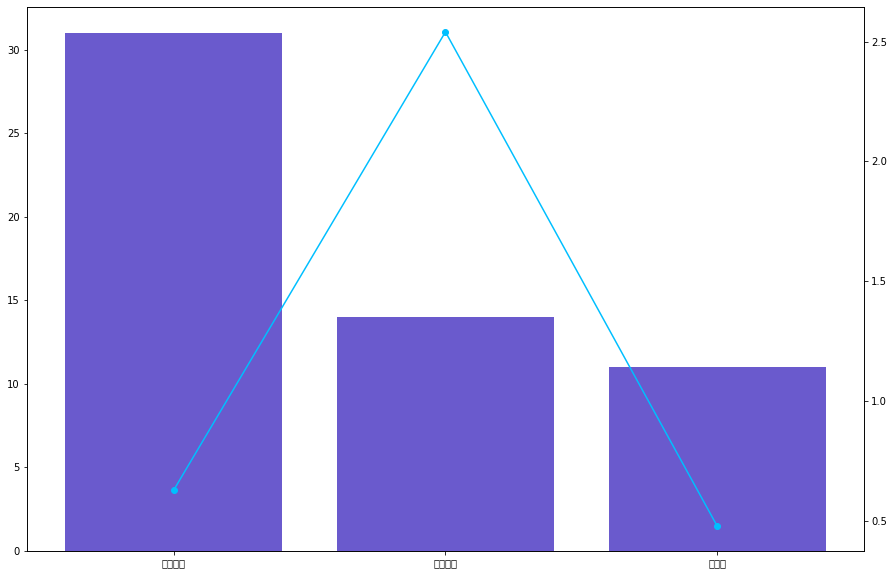

In [ ]:
fig = plt.figure(figsize=(15, 10))
sub = fig.add_subplot(111)
plt.rc("font", family='NanumGothic')
sub.bar(com_list, keyword_freq,color='slateblue',label='빈도수')

sub2 = sub.twinx()
sub2.plot(com_list, up_down_r,marker='o',color='deepskyblue',label='등락률')
plt.show()

##임시 저장소



In [ ]:
#file_list = os.listdir(news_link_dir)
#각 기업별 뉴스 기사 본문 추출 후 keywords 수 count
count_list = []
N = 30
for com in top100:
  count = Counter()
  with open(os.path.join(news_link_dir, com + '_naver_news.json'), 'r', encoding = 'utf-8') as f:
    json_data = json.load(f)
    for idx in range(0, 10):
      try:
        body = get_naver_news(json_data[idx]['link'])
      except:
        continue
      if body is None:
        continue
     
      text = body.get_text()

      news_body_start = []
      text_split = text.split(' ')
      rm_set = {''}
      text_split = [i for i in text_split if i not in rm_set]

      for word_index in range(0, len(text_split) - N):
        word_len = 0
        korean_word_len = 0
        for i in range(0, N):
          korean_word_len += koreanLen(text_split[word_index + i])
          word_len += len(text_split[word_index + i])
        news_body_start.append(korean_word_len / word_len)

      avg = []
      avg_index = []
      
      i = 0
      while i < len(text_split) - N:
        avg.append(sum(news_body_start[i:i + N]) / N)
        avg_index.append(i)
        i += N
      if len(avg) == 0:
        continue

      max_index = avg.index(max(avg))
      avg_avg = sum(avg) / len(avg)
      i = 0
      start = max_index
      end = max_index
      while max_index > i:
        if avg[max_index - i] > avg_avg:
          start = max_index - i
        else:
          break
        i += 1
      i = 0
      while (i + max_index) < len(avg):
        if avg[max_index + i] > avg_avg:
          end = max_index + i
        else:
          break
        i += 1
      count.update(getKorean(' '.join(text_split[avg_index[start] : avg_index[end] + N])))
    count_list.append(count)
      

In [ ]:
word_count = dict()
for tag, counts in count.most_common(5000):
    if(len(str(tag))>1):
        word_count[tag] = counts

In [ ]:
N = 30
count = Counter()
with open(os.path.join(news_link_dir, 'SK하이닉스_naver_news.json', ), 'r', encoding = 'utf-8') as f:
  #data = f.read().encode('utf-8').decode('unicode_escape')
  json_data = json.load(f)
  for i in range(0, 10):
    news_body = getNewsBody(json_data[i]['link'])
    if news_body is None:
      continue
    count.update(getKorean(news_body))
    #print(i, ' ', json_data[i]['link'], ' ', getKorean(news_body))
    

##형태소 분석

In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

from konlpy.tag import Mecab
mecab = Mecab()
sentence="여러 차례의 규제 완화 조치로 하늘길이 더 넓어질 것이라는 전망에 항공주와 레저주 일부 종목이 오름세다. 항공주는 지방 공항의 국제선 운항 재개가 유력해지면서 중소 저비용항공사(LCC) 중심으로 주가가 상승했다. 코로나19 사태 이전에 LCC는 지방 공항으로 사업 외연을 확장하면서 국제선 여객 중 48%나 담당할 정도로 빠르게 성장했다. 6일 오후 2시 기준 제주항공은 전 거래일 대비 2.75% 상승한 2만4300원에 거래 중이며, 이 밖에도 티웨이항공과 에어부산이 각각 1.86%, 0.63% 상승했다. 레저주도 소폭 오름세다. 모두투어가 전 거래일 대비 3.6%, 롯데관광개발은 1.93%, 하나투어도 1.11% 상승했다. 국제선 항공편이 증가하고 해외여행에 대한 욕구가 살아나면서 레저업계에 여행 패키지 상품이나 여행 관련 문의가 증가하고 있다. 실제 롯데관광개발이 3일 현대홈쇼핑에서 판매한 고가의 여행 패키지 상품이 70분 만에 1600건의 주문으로 약 260억원의 매출을 기록했다. 항공·레저주에 대해 증권업계에서는 아직 지켜볼 필요가 있다고 분석한다. 김현용 현대차증권 애널리스트는 “패키지여행 수요 회복은 빠르면 3분기에 감지될 것”이라면서 “전반적인 여행 수요가 급증할 것은 자명한 사실이지만 아직 코로나 이전의 25%에 불과하다”고 말했다. 김인식 IBK투자증권 애널리스트도 리오프닝주와 관련한 분석 보고서에서 “러시아-우크라이나 지정학적 리스크와 국제 유가 불안정성으로 아직은 경계해야 한다”고 말했다."
temp_X = mecab.pos(sentence)

temp_X


from konlpy.tag import Mecab
mecab = Mecab()
sentence="여러 차례의 규제 완화 조치로 하늘길이 더 넓어질 것이라는 전망에 항공주와 레저주 일부 종목이 오름세다. 항공주는 지방 공항의 국제선 운항 재개가 유력해지면서 중소 저비용항공사(LCC) 중심으로 주가가 상승했다. 코로나19 사태 이전에 LCC는 지방 공항으로 사업 외연을 확장하면서 국제선 여객 중 48%나 담당할 정도로 빠르게 성장했다. 6일 오후 2시 기준 제주항공은 전 거래일 대비 2.75% 상승한 2만4300원에 거래 중이며, 이 밖에도 티웨이항공과 에어부산이 각각 1.86%, 0.63% 상승했다. 레저주도 소폭 오름세다. 모두투어가 전 거래일 대비 3.6%, 롯데관광개발은 1.93%, 하나투어도 1.11% 상승했다. 국제선 항공편이 증가하고 해외여행에 대한 욕구가 살아나면서 레저업계에 여행 패키지 상품이나 여행 관련 문의가 증가하고 있다. 실제 롯데관광개발이 3일 현대홈쇼핑에서 판매한 고가의 여행 패키지 상품이 70분 만에 1600건의 주문으로 약 260억원의 매출을 기록했다. 항공·레저주에 대해 증권업계에서는 아직 지켜볼 필요가 있다고 분석한다. 김현용 현대차증권 애널리스트는 “패키지여행 수요 회복은 빠르면 3분기에 감지될 것”이라면서 “전반적인 여행 수요가 급증할 것은 자명한 사실이지만 아직 코로나 이전의 25%에 불과하다”고 말했다. 김인식 IBK투자증권 애널리스트도 리오프닝주와 관련한 분석 보고서에서 “러시아-우크라이나 지정학적 리스크와 국제 유가 불안정성으로 아직은 경계해야 한다”고 말했다."
temp_X = mecab.pos(sentence)
# http://openuiz.blogspot.com/2016/07/mecab-ko-dic.html
for i in temp_X:
    if i[1]=='NNG' or i[1]=='NNP' or i[1]=='VV' or i[1]=='VX' or i[1]=='VA':
	        if i[1]=='VA':#형용사 일때 '다'를 붙여줌 ex) 넓 + 다
            print(i[0]+'다', end=' ')
        else:
            print(i[0], end=' ')


from konlpy.tag import Mecab

def morpheme_separation(sentence):
    mecab = Mecab()
    split_sentence=[]
    temp_X = mecab.pos(sentence)
    # http://openuiz.blogspot.com/2016/07/mecab-ko-dic.html
    for i in temp_X:
        if i[1]=='NNG' or i[1]=='NNP' or i[1]=='VV' or i[1]=='VX' or i[1]=='VA':
                if i[1]=='VA':#형용사 일때 '다'를 붙여줌 ex) 넓 + 다
                    split_sentence.append(i[0]+'다')
                else:
                    split_sentence.append(i[0])
    return split_sentence

sentence="여러 차례의 규제 완화 조치로 하늘길이 더 넓어질 것이라는 전망에 항공주와 레저주 일부 종목이 오름세다. 항공주는 지방 공항의 국제선 운항 재개가 유력해지면서 중소 저비용항공사(LCC) 중심으로 주가가 상승했다. 코로나19 사태 이전에 LCC는 지방 공항으로 사업 외연을 확장하면서 국제선 여객 중 48%나 담당할 정도로 빠르게 성장했다. 6일 오후 2시 기준 제주항공은 전 거래일 대비 2.75% 상승한 2만4300원에 거래 중이며, 이 밖에도 티웨이항공과 에어부산이 각각 1.86%, 0.63% 상승했다. 레저주도 소폭 오름세다. 모두투어가 전 거래일 대비 3.6%, 롯데관광개발은 1.93%, 하나투어도 1.11% 상승했다. 국제선 항공편이 증가하고 해외여행에 대한 욕구가 살아나면서 레저업계에 여행 패키지 상품이나 여행 관련 문의가 증가하고 있다. 실제 롯데관광개발이 3일 현대홈쇼핑에서 판매한 고가의 여행 패키지 상품이 70분 만에 1600건의 주문으로 약 260억원의 매출을 기록했다. 항공·레저주에 대해 증권업계에서는 아직 지켜볼 필요가 있다고 분석한다. 김현용 현대차증권 애널리스트는 “패키지여행 수요 회복은 빠르면 3분기에 감지될 것”이라면서 “전반적인 여행 수요가 급증할 것은 자명한 사실이지만 아직 코로나 이전의 25%에 불과하다”고 말했다. 김인식 IBK투자증권 애널리스트도 리오프닝주와 관련한 분석 보고서에서 “러시아-우크라이나 지정학적 리스크와 국제 유가 불안정성으로 아직은 경계해야 한다”고 말했다."
morpheme_separation(sentence)